# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [1]:
import numpy as np
import cudaq

from cudaq_qlsa.qlsa.hhl import HHL
from cudaq_qlsa.generator import generate_problem
from cudaq_qlsa.noise_model import NoiseModeler
from cudaq_qlsa.executer import Executer
from cudaq_qlsa.post_processor import Post_Processor
from cudaq_qlsa.solver import QuantumLinearSolver
from cudaq_qlsa.refiner import Refiner

np.set_printoptions(edgeitems=30, linewidth=100000)

print('Cudaq version:', cudaq.__version__)
print('Running on backend', cudaq.get_target())

Cudaq version: CUDA-Q Version 0.11.0 (https://github.com/NVIDIA/cuda-quantum f5cc3bb1d85abcf1f642f4ddd20ad08bc1d4d200)
Running on backend Target nvidia
	simulator=cusvsim_fp32
	platform=default
	description=The NVIDIA Target provides a simulated QPU via cuStateVec (state-vector simulation) integration.
	precision=fp32
Supported Arguments:
  - option (Specify the target options as a comma-separated list.
Supported options are 'fp32', 'fp64', 'mgpu', 'mqpu'.
For example, the 'fp32,mgpu' option combination will activate multi-GPU distribution with single-precision. Not all option combinations are supported.)



# Step 0: **Define** the (classical) problem

In [2]:
prob = generate_problem(n=8, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")

A: [[ 1.25443337e+00 -1.04861115e-01 -3.83603309e-16  1.98064596e-02 -9.44103082e-17 -2.60849077e-01 -1.51594382e-01 -2.34872454e-16]
 [-1.04861115e-01  2.23466620e+00 -3.37281869e-01 -2.98719127e-01 -1.70441485e-16 -5.97132489e-01  1.28688054e-15 -8.93977823e-17]
 [-3.83603309e-16 -3.37281869e-01  1.87410588e+00  4.53911103e-01 -2.56732302e-01  5.20994807e-16  1.87346895e-16  3.06937805e-01]
 [ 1.98064596e-02 -2.98719127e-01  4.53911103e-01  2.34633913e+00  1.73303040e-01  4.04160031e-16  9.45777108e-16 -1.80480503e-16]
 [-9.44103082e-17 -1.70441485e-16 -2.56732302e-01  1.73303040e-01  1.02563574e+00 -2.08144566e-16  2.97659781e-16 -6.33144014e-02]
 [-2.60849077e-01 -5.97132489e-01  5.20994807e-16  4.04160031e-16 -2.08144566e-16  1.43280413e+00  4.99649356e-01  5.24471266e-16]
 [-1.51594382e-01  1.28688054e-15  1.87346895e-16  9.45777108e-16  2.97659781e-16  4.99649356e-01  1.04259058e+00  1.95706212e-16]
 [-2.34872454e-16 -8.93977823e-17  3.06937805e-01 -1.80480503e-16 -6.33144014e-0

## Step 1: **Map** problem to quantum circuits and operators

In [3]:
hhl = HHL(
    readout = 'measure_x',
    # swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = 3,
    t0 = 2 * np.pi)

In [4]:
kernel, args = hhl.build_circuit(A, b)

In [5]:
hhl.draw(A, b)

                                                                             »
q0 : ────────────────────────────────────────────────────────────────────────»
     ╭───╮                                                                   »
q1 : ┤ h ├───────●──────────────────●─────────────────●──────────────────────»
     ├───┤       │                  │                 │                      »
q2 : ┤ h ├───────┼──────────────────┼─────────────────┼──────────────────────»
     ├───┤       │                  │                 │                      »
q3 : ┤ h ├───────┼──────────────────┼─────────────────┼──────────────────────»
     ╰───╯       │                  │                 │                      »
q4 : ────────────┼──────────────────┼─────────────────┼──────────────────────»
                 │                  │      ╭───╮╭─────┴──────╮╭───╮╭───╮     »
q5 : ────────────┼──────────────────┼──────┤ h ├┤ rz(0.2346) ├┤ h ├┤ h ├──●──»
     ╭───╮╭──────┴──────╮╭───╮╭─────┴─────╮├───┤╰───

## Step 2: **Optimize** for target hardware

Cudaq does not have dedicated transpile. Also, backends only vary between CPU and GPU. 

In [6]:
'''
NOT WORKING IN Cudaq 0.12.0 or OLDER 
'''
# resources = cudaq.estimate_resources(kernel, args)
# print(resources)

'\nNOT WORKING IN Cudaq 0.12.0 or OLDER \n'

## Step 3: **Execute** on target hardware

In [7]:
noisemodeler = NoiseModeler()
noise_config = [0.5, 0.5, 'depolarization', 'depolarization']
noise_model  = noisemodeler.noise_modeler(noise_config)

In [8]:
executer = Executer()

result = executer.run(
    kernel = kernel,
    args = args,
    backend = 'nvidia', 
    shots = 1024,
    noise_model = noise_model
    )

Noisy simulation underway ...


## Step 4: **Process** result to obtain classical solution

In [9]:
processor = Post_Processor()
solution = processor.process(result, A, b)
solution

array([-0.33520076, -0.34347857, -0.3238347 , -0.35156152, -0.34074165, -0.33239568, -0.39661489,  0.39661489])

## Wrapping steps 1-4 together in a solver:


In [10]:
hhl_solver = QuantumLinearSolver(
    qlsa = hhl,
    backend = 'nvidia',
    shots = 1024,
    noisemodel = noise_model,
    executer = executer,
    post_processor = processor)

hhl_solution = hhl_solver.solve(A, b)
print(f"Solution: {hhl_solution}")

Noisy simulation underway ...
Solution: [-0.40677712 -0.32298072 -0.32575314 -0.32575314 -0.35482289 -0.39099578 -0.34971725  0.34191589]


## Integrate **Iterative Refinement** to improve accuracy

Noisy simulation underway ...
Initial residual: 1.0042, Initial error: 0.6217

IR Iteration: 1
Noisy simulation underway ...
  IR System residual: 2.7290
  residual: 4.40e-01, error: 2.07e-01
.............................................................
IR Iteration: 2
Noisy simulation underway ...
  IR System residual: 2.4020
  residual: 2.55e-01, error: 3.00e-01
.............................................................
IR Iteration: 3
Noisy simulation underway ...
  IR System residual: 2.7128
  residual: 1.05e-01, error: 2.09e-01
.............................................................
IR Iteration: 4
Noisy simulation underway ...
  IR System residual: 2.2808
  residual: 6.23e-02, error: 2.60e-01
.............................................................
IR Iteration: 5
Noisy simulation underway ...
  IR System residual: 2.6863
  residual: 3.33e-02, error: 3.03e-01
.............................................................
IR Iteration: 6
Noisy simulation underway ...


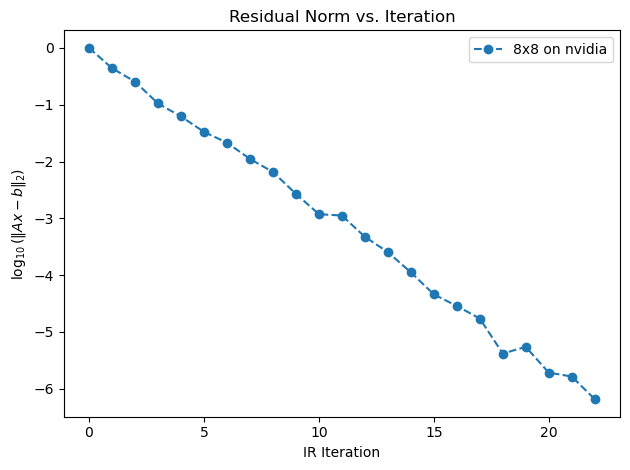

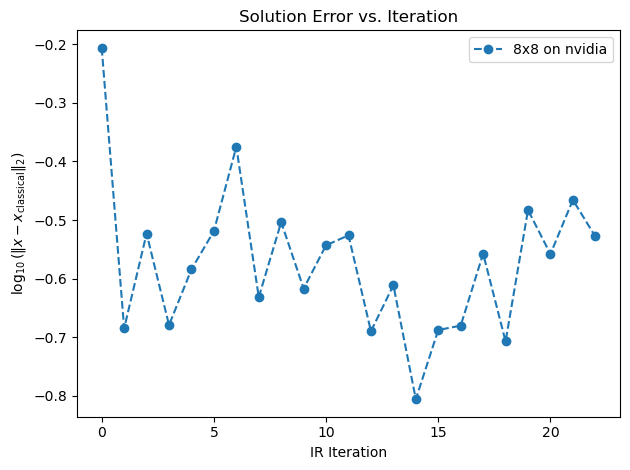

In [11]:
refiner = Refiner(A = A, b = b, solver = hhl_solver)
refined_solution = refiner.refine(precision = 1e-6, max_iter = 100, plot=True)

In [12]:
print('Refined quantum solution:')
refined_solution['refined_x']

Refined quantum solution:


array([-0.54026963, -0.07738361, -0.39297703, -0.00767202, -0.5289788 , -0.19097319, -0.07900065,  0.07495451])

In [13]:
print('Classical solution:')
np.linalg.solve(A,b)

Classical solution:


array([-0.54026973, -0.07738379, -0.39297711, -0.00767202, -0.52897914, -0.1909733 , -0.07900065,  0.07495426])